In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime

In [3]:
def convert_to_date(x):
    return datetime.strptime(x, '%Y %m %d')

In [4]:
data=pd.read_csv('twins_1992-1997.csv',parse_dates=[['year','month','day']],date_parser=convert_to_date,keep_date_col=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_10320\1545339538.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data=pd.read_csv('twins_1992-1997.csv',parse_dates=[['year','month','day']],date_parser=convert_to_date,keep_date_col=True)


In [5]:
data=data.dropna(subset=['air temp.'])

In [6]:
data['humidity']=data['humidity'].interpolate()

In [7]:
data['zon.winds'].fillna(np.random.normal(data['zon.winds'].mean(),data['zon.winds'].std()),inplace=True)
data['mer.winds'].fillna(np.random.normal(data['mer.winds'].mean(),data['mer.winds'].std()),inplace=True)

In [8]:
data['humidity']=data['humidity'].fillna(data['humidity'].mean(),)

In [9]:
data.count()

year_month_day    72158
year              72158
month             72158
day               72158
latitude          72158
longitude         72158
zon.winds         72158
mer.winds         72158
humidity          72158
air temp.         72158
s.s.temp.         72158
dtype: int64

In [10]:

features = ['longitude', 'latitude', 'air temp.', 'humidity', 'mer.winds', 'zon.winds', 's.s.temp.']
data = data[features]


In [11]:

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

scaled_data = pd.DataFrame(scaled_data, columns=features, index=data.index)

sequence_length = 60

def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length].values
        target = data.iloc[i+sequence_length]['s.s.temp.']
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

X, y = create_sequences(scaled_data, sequence_length)


In [12]:


split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, len(features))))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
1442/1442 [==============================] - 93s 61ms/step - loss: 0.0242 - val_loss: 0.0332
Epoch 2/20
1442/1442 [==============================] - 88s 61ms/step - loss: 0.0214 - val_loss: 0.0345
Epoch 3/20
1442/1442 [==============================] - 86s 60ms/step - loss: 0.0207 - val_loss: 0.0345
Epoch 4/20
1442/1442 [==============================] - 87s 60ms/step - loss: 0.0201 - val_loss: 0.0340
Epoch 5/20
1442/1442 [==============================] - 88s 61ms/step - loss: 0.0197 - val_loss: 0.0345
Epoch 6/20
1442/1442 [==============================] - 83s 58ms/step - loss: 0.0195 - val_loss: 0.0331
Epoch 7/20
1442/1442 [==============================] - 81s 56ms/step - loss: 0.0193 - val_loss: 0.0358
Epoch 8/20
1442/1442 [==============================] - 78s 54ms/step - loss: 0.0192 - val_loss: 0.0338
Epoch 9/20
1442/1442 [==============================] - 86s 59ms/step - loss: 0.0191 - val_loss: 0.0348
Epoch 10/20
1442/1442 [==============================] - 88s 61m

In [13]:



y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values
y_test = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), len(features)-1)), y_test.reshape(-1, 1)], axis=1))[:, -1]
y_pred = scaler.inverse_transform(np.concatenate([np.zeros((len(y_pred), len(features)-1)), y_pred], axis=1))[:, -1]

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')



451/451 [==============================] - 12s 25ms/step
Mean Squared Error: 4.949178533776575


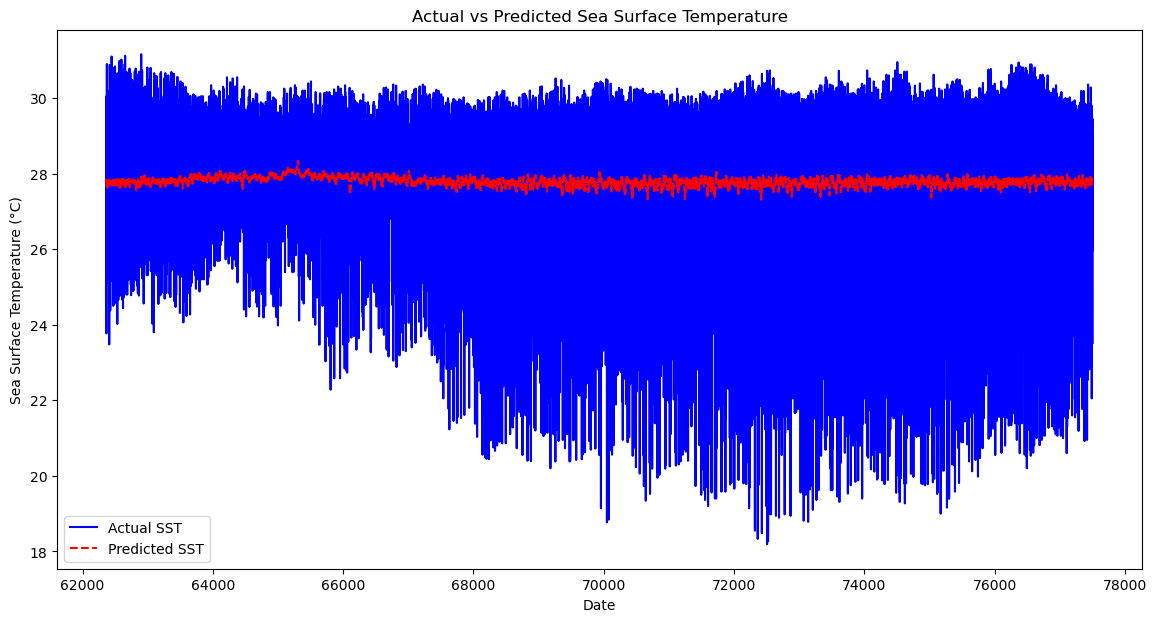

In [14]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test, label='Actual SST', color='blue')
plt.plot(data.index[-len(y_test):], y_pred, label='Predicted SST', color='red', linestyle='--')
plt.legend()
plt.title('Actual vs Predicted Sea Surface Temperature')
plt.xlabel('Date')
plt.ylabel('Sea Surface Temperature (°C)')
plt.show()
